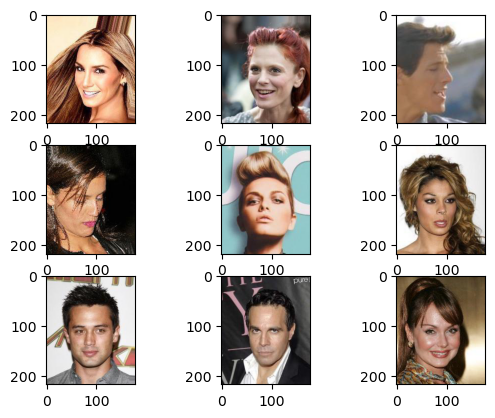

In [2]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image

# 이미지까지의 경로
image_path = "./data/sample"
images = glob.glob(os.path.join(image_path, "*"))


# 9개의 이미지를 보여줌
for i in range(9):
   plt.subplot(3, 3, i+1)
   image = Image.open(images[i])
   plt.imshow(image)

plt.show()

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import cv2

epochs = 10
image_w = 256
image_h = 256


selected_category = "Male" # 학습할 카테고리 Male, Young, Eyeglasses, Smiling, Wearing_Hat
model_name = "s_" + selected_category.lower() # 샘플 학습
#model_name = selected_category.lower()
hdf5_file = "./models/" + model_name + ".hdf5" # 모델 저장 위치

def model_train():
    # 이미지 디렉토리와 레이블 파일 경로
    img_dir = './data/sample' # 샘플
    label_file = './data/sample.txt'
    #img_dir = './original_data/img_align_celeba' # 원본
    #label_file = './original_data/list_attr_celeba.txt'
    
    # 카테고리 정보 매핑
    with open(label_file, 'r') as f:
        category_line = next(f).strip().split()
        category_mapping = {category: idx for idx, category in enumerate(category_line)}
    
    # 카테고리 선택
    selected_category_indices = [category_mapping[selected_category]]
    
    # 이미지 파일 경로 및 레이블 추출
    image_paths = []
    labels = []
    
    with open(label_file, 'r') as f:
        next(f)  # 첫 번째 줄은 헤더이므로 건너뜁니다.
        for line in f:
            tokens = line.strip().split()
            image_paths.append(os.path.join(img_dir, tokens[0]))
            # 선택한 카테고리에 해당하는 레이블만 추출하여 추가
            selected_labels = [int(tokens[idx]) for idx in selected_category_indices]
            labels.append(selected_labels)
    
    # 이미지를 넘파이 배열로 로드하고 전처리
    images = []  
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 필요한 전처리 작업 수행 (크기 조정, 색상 채널 변경 등)
        resized_face = cv2.resize(image, (image_w, image_h))
        # 이미지를 넘파이 배열로 변환하여 리스트에 추가
        images.append(np.array(resized_face))
    
    # 이미지와 레이블을 넘파이 배열로 변환
    images = np.array(images)
    labels = np.array(labels)

In [ ]:
# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_test = X_train / 255.0, X_test / 255.0

# 기본 모델(VGG16) 로딩
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_w, image_h, 3))

# 새로운 모델 생성
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 확인
base_model.summary()
model.summary()

In [ ]:
# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rotation_range=20)

# 데이터 증강 적용을 위해 이미지 데이터 형태를 맞춰줍니다.
X_train = X_train.reshape(X_train.shape[0], image_w, image_h, 3)

# 모델 훈련을 위해 데이터 증강 적용
train_datagen.fit(X_train)

# 모델 학습
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), 
                validation_data=(X_test, y_test), 
                epochs=epochs)

# 모델 저장하기
model.save(hdf5_file)

# 모델 평가
model.evaluate(X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_data = 3
predictions = model.predict(X_test)
# 최소값과 최대값 계산
min_val = np.min(predictions)
max_val = np.max(predictions)

# 최소-최대 정규화 수행
normalized_arr = (predictions - min_val) / (max_val - min_val)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(X_test[test_data], cmap=plt.cm.binary)

plt.subplot(1,2,2)
plt.xticks(range(len(selected_categories)))
plt.yticks(np.arange(0, 1.1, 0.1))
thisplot = plt.bar(selected_categories, normalized_arr[test_data], color="gray")
plt.ylim([0, 1])

for i, pre in enumerate(normalized_arr[test_data]):
    if pre >= 0.5 :
        plt.bar(selected_categories[i], normalized_arr[test_data][i], color='green')

plt.show()